### Analysis at reaction level

In [ ]:
gcfront_strategies_df = pd.read_csv('../data/gcfront_strategies_evaluation.csv')

configured_model = cobra.io.load_matlab_model('../models/configured_model.mat')
target_biomass = 'BiomassKT2440_ME'
target_reaction = 'DM_C80aPHA'
carbon_source = 'EX_pet(e)'

gdls_result= ['ABUTD','ALAR','ALATA_L','FORGLUIH2','ICDHyr','ICL','MALS','MCITL2','OARGDC','ORNCD','PDHbr','PDHcr','PPCSCT','RBK','SUCOAS','UPPN']

In [28]:
#GENERATE DATAFRAME:
equi_list = [d
             for s in gcfront_strategies_df['ReactionDeletions'].tolist() 
             for d in s.split(' ') ]

rxns_list = [g if '/' in eq else eq 
target_biomass = 'BiomassKT2440_ME'
target_reaction = 'DM_C80aPHA'
carbon_source = 'EX_pet(e)'for eq in set(equi_list) 
             for g in eq.split('/')]

presence_list = []
biomass_list = []
flux_list = []
coupling_list = []

for r in rxns_list:
    present_in = gcfront_strategies_df.loc[gcfront_strategies_df['ReactionDeletions'].str.contains(r)]
    presence_list.append(len(present_in)/len(gcfront_strategies_df))
    biomass_list.append(present_in['GrowthRate'].median())
    flux_list.append(present_in['ProductFlux'].median())
    coupling_list.append(present_in['CouplingStrength'].median())

rxns_dict = {'Reaction': rxns_list,
             'Presence': presence_list,
             'Median_Biomass': biomass_list,
             'Median_Flux': flux_list,
             'Median_Coupling_Strength':coupling_list}

df = pd.DataFrame.from_dict(rxns_dict)
df

,Reaction,Presence,Median_Biomass,Median_Flux,Median_Coupling_Strength
0,P5CD,0.222267,0.231194,0.718116,0.579694
1,3HBCD,0.010121,0.115542,1.043616,0.670512
2,CSND,0.031984,0.110092,1.129592,0.570026
3,OIVD1r,0.009447,0.113268,1.115383,0.541978
4,PYK,0.071795,0.260050,0.700769,0.538554
...,...,...,...,...,...
183,ECOAH27,0.009312,0.200265,0.862667,0.541980
184,FDH,0.001080,0.102171,1.156573,0.681578
185,PPKr,0.157355,0.215832,0.913115,0.268293
186,FACOAE60,0.003509,0.156352,0.991256,0.759231


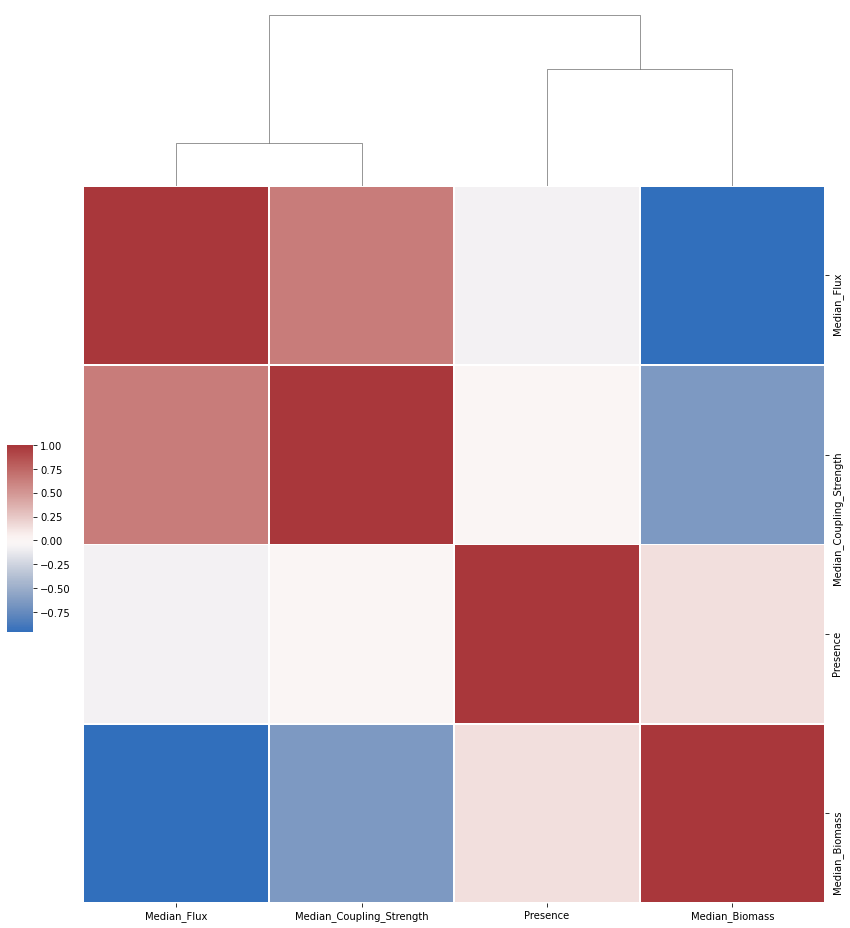

In [30]:
#CORRELATION CLUSTER MAP OF GENE'S SELECTION PARAMETERS:
import seaborn as sns

g = sns.clustermap(df.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()

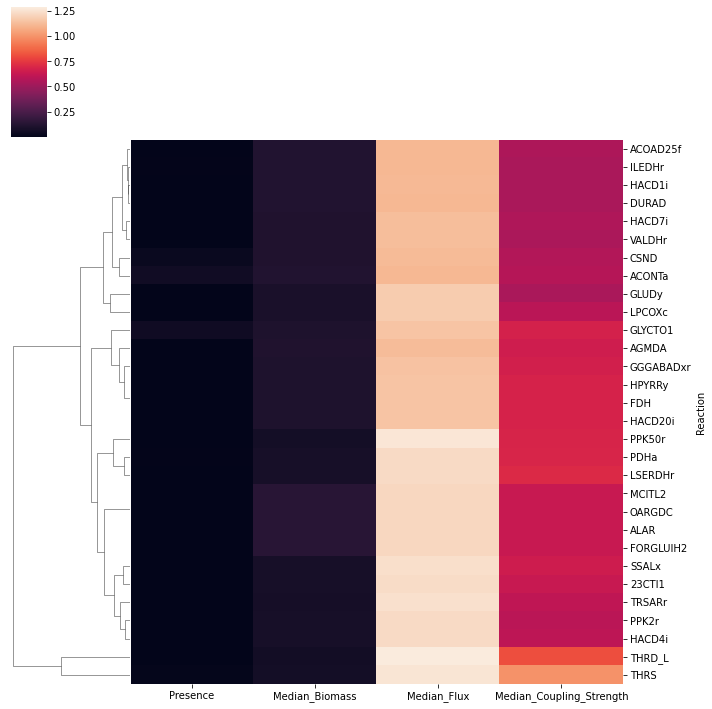

In [31]:
#CLUSTER MAP OF REACTION'S SELECTION PARAMETERS:
top = 30
parameter = 'Median_Flux'
plot_df = df.sort_values(by=parameter, ascending=False)
plot_df = plot_df.drop_duplicates()
plot_df = plot_df[:top]
plot_df = plot_df.set_index(['Reaction'])
g = sns.clustermap(plot_df)
g.ax_col_dendrogram.remove()

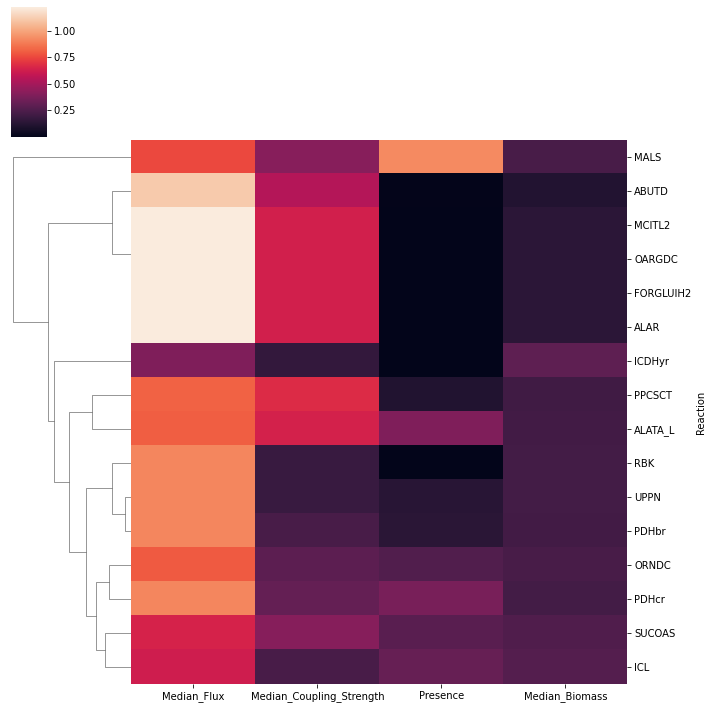

In [33]:
#CLUSTER MAP OF REACTIONS IN gdls_result:
plot_df = df.loc[df['Reaction'].isin(gdls_result)]
plot_df = plot_df.drop_duplicates()
plot_df = plot_df.set_index(['Reaction'])
g = sns.clustermap(plot_df)
g.ax_col_dendrogram.remove()

### Plot escher maps for the best workflow solutions and GDLS solution

In [33]:
##### import escher
from escher import Builder

map_model = configured_model.copy()

for rxn in intermediate_gdls:
    map_model.reactions.get_by_id(rxn).knock_out()

builder = Builder(
    map_json='../data/new_map_pet_to_pha.json',
    model= map_model,
    reaction_scale_preset = 'GaBuRd'
)

builder.reaction_data = builder.model.optimize().fluxes
builder

Read LP format model from file /tmp/tmphi2mz2fh.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros


Builder(reaction_data={'1PPDCRc': 0.0, '23CTI1': 0.0, '2AACLPGT160': 0.0, '2AACLPGT161': 0.0, '2AACLPGT180': 0…

No significant increase in the strategy after the combinations

In [ ]:
def apply_ko_strategy(model, ko_strategy):
    model = model.copy()
    for r in ko_strategy:
        model.reactions.get_by_id(r).bounds = (0,0)
        
    return model

def coupling_strength(model, target_reaction, target_biomass, carbon_source):

    prod_env = production_envelope(model, 
                                   [target_biomass], 
                                   objective=target_reaction, 
                                   carbon_sources=carbon_source)  
    '''
    AS the score is compute differently depending if reaction is coupled, first compute
    the decision parameter to check if solution couple or not the production with the
    growth. Coupling means that in the envelope, the minimum of the points where the 
    biomass is equal to its maximum should be above 0 (there is production at maximum
    growth).This value is computed in the following variable:
    '''
    max_growth = max(prod_env[target_biomass].tolist())
    min_p_max_growth = min(prod_env.loc[prod_env[target_biomass]==max_growth,
                                                 'flux_minimum' ].tolist())
    
    is_coupled = min_p_max_growth > 0
    
    
    if is_coupled:
        '''
        Before the computation compute the rest of needed parameters:
        min_p_no_growth : minimum production of target when there is no growth
        max_growth_no_p : maximum growth when there is no production
        '''
        min_p_no_growth = min(prod_env.loc[prod_env[target_biomass]==0,
                                                    'flux_minimum' ].tolist())
        
        min_p = min(prod_env['flux_minimum'].tolist())
        if min_p > 0:
            max_growth_no_p = 0
        else:
            max_growth_no_p = max(prod_env.loc[prod_env['flux_minimum']==0,
                                               target_biomass].tolist())
            
        coupling_strength = min([1,(min_p_no_growth/min_p_max_growth)]) + ((max_growth-max_growth_no_p)/max_growth)
        
    if not is_coupled:
        '''
        Before the computation compute the rest of needed parameters:
        max_growth_delta_p : maximum growth when the production is forced to a
                             minimum value above 0, called delta
        
        Here delta will be the minimum nonzero value in the flux_maximum column
        '''
        delta = min(prod_env.loc[prod_env['flux_maximum']>0, 'flux_maximum'].tolist())
        max_growth_delta_p = max(prod_env.loc[prod_env['flux_maximum']==delta,
                                              target_biomass].tolist())
        
        coupling_strength = (max_growth-max_growth_delta_p)/delta
    
    return coupling_strength, is_coupled
    

def rank_strategy_reactions(model, ko_strategy, target_reaction, target_biomass, carbon_source):
    production_impact_list = []
    coupling_strength_impact_list = []
    score_list = []
    decouple_list = []
    model_with_original_strategy = apply_ko_strategy(model, ko_strategy)
    pfba_sol_wt = pfba(model_with_original_strategy)
    coupling_strength_strategy, wt_coupled = coupling_strength(model_with_original_strategy, target_reaction, target_biomass, carbon_source)
    
    for r in ko_strategy:
        variant_strategy = list(set(ko_strategy) - {r})
        model_with_variant_strategy = apply_ko_strategy(model, variant_strategy)
        pfba_sol = pfba(model_with_variant_strategy)
        coupling_strength_variant, var_coupled = coupling_strength(model_with_variant_strategy, target_reaction, target_biomass, carbon_source)
        flux_impact = pfba_sol.fluxes[target_reaction]-pfba_sol_wt.fluxes[target_reaction]
        coupling_strength_impact = coupling_strength_variant - coupling_strength_strategy
        production_impact_list.append(flux_impact)
        coupling_strength_impact_list.append(coupling_strength_impact)
        score_list.append(0.5*flux_impact+0.5*coupling_strength_impact)
        decoupling = wt_coupled and not var_coupled
        decouple_list.append(decoupling)
    
    final_data = {'Reaction_ID' : ko_strategy,
                  'Flux_impact' : production_impact_list,
                  'Coupling_strength_impact' : coupling_strength_impact_list,
                  'Impact_Score' : score_list,
                  'Decoupling_effect' : decouple_list}
    
    df = pd.DataFrame.from_dict(final_data)
    
    ranking = df.sort_values(by='Impact_Score')
    
    return ranking
           

In [17]:
ranking = rank_strategy_reactions(configured_model, gdls_result, target_reaction, target_biomass, carbon_source)

Read LP format model from file /tmp/tmpqxyxo2d6.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmp8iw163bb.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmp2csfiu8b.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmpxk6wq0i7.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmp6bjcw5gf.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmp6ujg7jvp.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmp2ai92yl_.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /tmp/tmpfev6sf40.lp
Reading time = 0.01 seconds
: 2112 rows, 2770 columns, 11744 nonzeros
Read LP format model from file /

In [18]:
ranking

,Reaction_ID,Flux_impact,Coupling_strength_impact,Impact_Score,Decoupling_effect
9,ORNCD,-1.222733e+00,-0.616941,-9.198371e-01,True
4,ICDHyr,-1.222733e+00,-0.539116,-8.809247e-01,True
6,MALS,-1.222733e+00,-0.526015,-8.743741e-01,True
5,ICL,-1.222733e+00,-0.486660,-8.546966e-01,True
12,PPCSCT,-2.757089e-01,-0.526316,-4.010124e-01,False
14,SUCOAS,-2.757089e-01,-0.526316,-4.010124e-01,False
3,FORGLUIH2,-4.695664e-01,-0.210526,-3.400464e-01,False
7,MCITL2,-8.271214e-02,-0.421053,-2.518824e-01,False
11,PDHcr,-2.559222e-01,-0.157895,-2.069085e-01,False
10,PDHbr,-1.722552e-01,-0.105263,-1.387592e-01,False


In [51]:
my_palette=sns.choose_colorbrewer_palette('sequential')

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

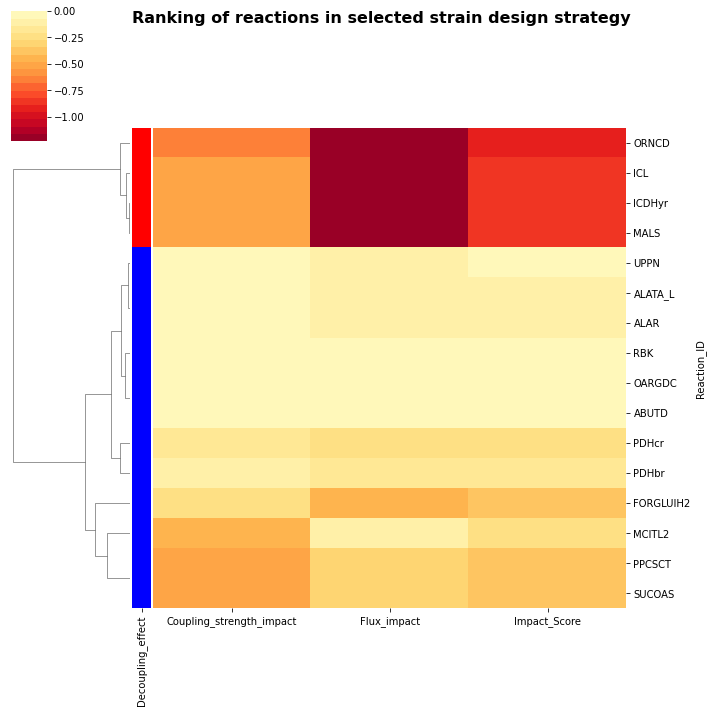

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
ranking['Decoupling_effect'] = [1 if d==True else 0 for d in ranking['Decoupling_effect'].tolist()]
plot_df = ranking.set_index(['Reaction_ID'])
#plot_df.pop('index')
decoupling = plot_df.pop("Decoupling_effect")
lut = dict(zip(decoupling.unique(), "rbg"))
row_colors = decoupling.map(lut)
g = sns.clustermap(plot_df,cmap=my_palette,row_colors=row_colors)
g.fig.suptitle('Ranking of reactions in selected strain design strategy',
               x=0.535, fontsize=16, fontweight='bold')
g.ax_col_dendrogram.remove()
plt.savefig('reaction_impact_ranking.svg', dpi=300)